In [1]:
# Algorithm implementation
import numpy as np
from scipy.spatial.distance import cdist

# Show subsampling
from collections import Counter

# Example usage
RANDOM_STATE = 42
np.random.seed = RANDOM_STATE

from tqdm import trange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
def qbrs(X, y, n):
    def calculate_quantiles(X, q):
        quantiles = []
        for i in range(X.shape[1]):
            quantiles.append(np.percentile(X[:, i], np.linspace(0, 100, q + 1)))
        return quantiles

    def find_closest_sample(combination, X, quantiles):
        distances = cdist([combination], X, metric='euclidean')
        return np.argmin(distances)

    d = X.shape[1]
    q = int(np.floor(n**(1/d)))
    quantiles = calculate_quantiles(X, q)

    combinations = np.array(np.meshgrid(*quantiles)).T.reshape(-1, d)
    subset_indices = []

    for combination in combinations:
        idx = find_closest_sample(combination, X, quantiles)
        if idx not in subset_indices:
            subset_indices.append(idx)

    X_sub = X[subset_indices]
    y_sub = y[subset_indices]

    return X_sub, y_sub

In [3]:
# Load example dataset
data = load_iris()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Get representative subset using QBRS
n = 30
X_sub, y_sub = qbrs(X_train, y_train, n)

print(f'Superset ({len(X_train)}): {Counter(y_train)}\nSubset ({len(X_sub)}):   {Counter(y_sub)}')

Superset (120): Counter({1: 41, 0: 40, 2: 39})
Subset (32):   Counter({1: 13, 2: 10, 0: 9})


In [4]:
model = MLPClassifier((4, 3), random_state=RANDOM_STATE)

accuracy_superset = []
accuracy_subset = []
for i in trange(1, 3000, 30):
    model.max_iter = i
    # Train and evaluate the model
    model.fit(X_train, y_train)
    accuracy_superset.append(model.score(X_test, y_test))
    model.fit(X_sub, y_sub)
    accuracy_subset.append(model.score(X_test, y_test))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


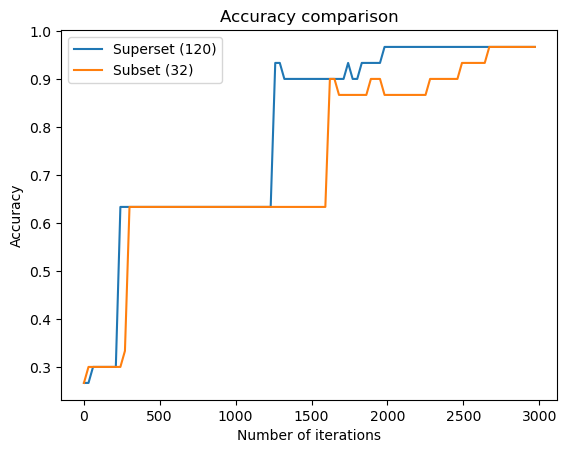

In [5]:
# Plot the accuracies
x = np.arange(1, 3000, 30)
plt.plot(x, accuracy_superset, label=f'Superset ({len(X_train)})')
plt.plot(x, accuracy_subset, label=f'Subset ({len(X_sub)})')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy comparison')
plt.legend()
plt.show()